# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

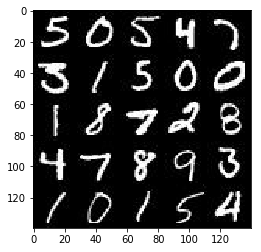

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

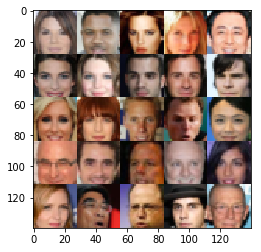

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    intput_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, 
                                                     image_channels), name="input_real")
    learning_rate = tf.placeholder(tf.float32, shape=None, name="learning_rate")
    return intput_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    stddev = 0.02
    with tf.variable_scope("discriminator", reuse=reuse):
        # 1st conv layer with 64 filters, 14*14*64
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha*x1, x1)
        
        # 2nd conv layer with 128 filters, 7*7*128
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*x2, x2)
        
        # 3rd conv layer with 256 filters, 4*4*256
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*x3, x3)
        
        flatten = tf.reshape(relu3, shape=(-1, 4*4*256))

        output = tf.layers.dense(flatten, 1)
        
        logits = tf.sigmoid(output)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 4*4*256)
        x = tf.reshape(x, shape=(-1, 4, 4, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        # 1st transposed convolution
        conv1 = tf.layers.conv2d_transpose(x, filters=128, kernel_size=4, strides=1,
                                          padding='valid', 
                                          kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # 2nd transposed convolution
        conv2 = tf.layers.conv2d_transpose(conv1, filters=64, kernel_size=5, strides=2,
                                          padding='same',
                                          kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        # 3rd transposed convolution
        conv3 = tf.layers.conv2d_transpose(conv2, filters=32, kernel_size=5, strides=2,
                                          padding='same',
                                          kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        logits = tf.layers.conv2d_transpose(conv3, filters=out_channel_dim, kernel_size=3,
                                           strides=1, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_out = generator(input_z, out_channel_dim)
    dis_out_real, dis_logits_real = discriminator(input_real)
    dis_out_fake, dis_logits_fake = discriminator(gen_out, reuse=True)
    
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_out_fake, labels=tf.zeros_like(dis_out_fake)))
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_out_real, labels=tf.ones_like(dis_out_real)*0.9
        )
    )
    dis_loss = dis_loss_fake + dis_loss_real
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_out_fake,
                            labels=tf.ones_like(dis_out_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        return dis_train_ops, gen_train_ops
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width, image_height, image_channels = data_shape[1:]
    input_real, input_z, learning_rate_tensor = model_inputs(image_width, image_height, image_channels,
                                                      z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train, g_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every_ = 100
    print_every_ = 20
    step = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate_tensor: learning_rate })
                sess.run(g_train, feed_dict={ input_z: batch_z, learning_rate_tensor: learning_rate })
                
                if step % show_every_ == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                if step % print_every_ == 0:
                    dis_loss_train = d_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = g_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("The Discriminator Loss is: %.3f..." % dis_loss_train,
                         "and the Generator Loss is: %.3f" % gen_loss_train)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

The Discriminator Loss is: 0.407... and the Generator Loss is: 3.339
The Discriminator Loss is: 0.484... and the Generator Loss is: 2.469
The Discriminator Loss is: 0.532... and the Generator Loss is: 2.318
The Discriminator Loss is: 0.841... and the Generator Loss is: 1.296


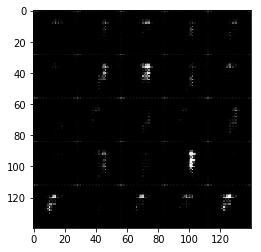

The Discriminator Loss is: 0.619... and the Generator Loss is: 1.838
The Discriminator Loss is: 0.840... and the Generator Loss is: 1.616
The Discriminator Loss is: 0.885... and the Generator Loss is: 1.848
The Discriminator Loss is: 0.813... and the Generator Loss is: 1.565
The Discriminator Loss is: 0.982... and the Generator Loss is: 1.433


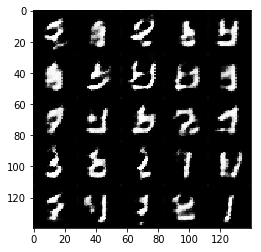

The Discriminator Loss is: 0.797... and the Generator Loss is: 1.507
The Discriminator Loss is: 1.192... and the Generator Loss is: 0.717
The Discriminator Loss is: 0.946... and the Generator Loss is: 1.902
The Discriminator Loss is: 1.096... and the Generator Loss is: 1.250
The Discriminator Loss is: 1.025... and the Generator Loss is: 0.940


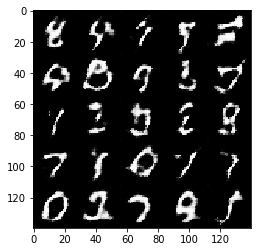

The Discriminator Loss is: 0.852... and the Generator Loss is: 1.620
The Discriminator Loss is: 1.160... and the Generator Loss is: 0.915
The Discriminator Loss is: 1.011... and the Generator Loss is: 1.016
The Discriminator Loss is: 1.073... and the Generator Loss is: 1.333
The Discriminator Loss is: 1.590... and the Generator Loss is: 2.433


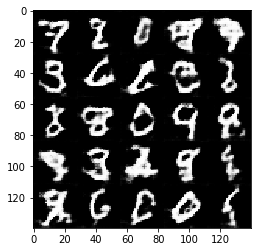

The Discriminator Loss is: 1.101... and the Generator Loss is: 0.971
The Discriminator Loss is: 1.223... and the Generator Loss is: 0.949
The Discriminator Loss is: 1.332... and the Generator Loss is: 0.645
The Discriminator Loss is: 1.305... and the Generator Loss is: 0.599
The Discriminator Loss is: 1.052... and the Generator Loss is: 1.104


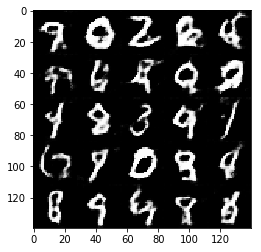

The Discriminator Loss is: 1.171... and the Generator Loss is: 1.329
The Discriminator Loss is: 1.196... and the Generator Loss is: 0.713
The Discriminator Loss is: 1.113... and the Generator Loss is: 0.901
The Discriminator Loss is: 1.099... and the Generator Loss is: 1.242
The Discriminator Loss is: 1.058... and the Generator Loss is: 1.268


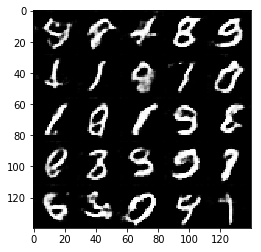

The Discriminator Loss is: 1.138... and the Generator Loss is: 1.006
The Discriminator Loss is: 1.292... and the Generator Loss is: 0.768
The Discriminator Loss is: 1.303... and the Generator Loss is: 1.867
The Discriminator Loss is: 1.284... and the Generator Loss is: 1.969
The Discriminator Loss is: 1.104... and the Generator Loss is: 1.006


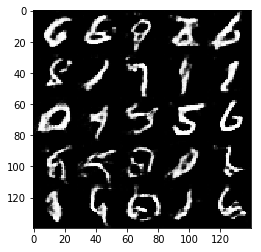

The Discriminator Loss is: 1.210... and the Generator Loss is: 0.900
The Discriminator Loss is: 1.086... and the Generator Loss is: 1.275
The Discriminator Loss is: 1.121... and the Generator Loss is: 0.817
The Discriminator Loss is: 1.408... and the Generator Loss is: 0.563
The Discriminator Loss is: 1.391... and the Generator Loss is: 0.527


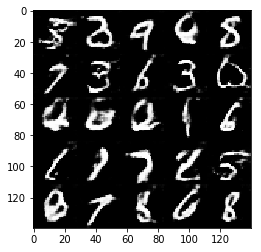

The Discriminator Loss is: 1.133... and the Generator Loss is: 0.984
The Discriminator Loss is: 1.103... and the Generator Loss is: 0.926
The Discriminator Loss is: 1.011... and the Generator Loss is: 1.441
The Discriminator Loss is: 1.165... and the Generator Loss is: 0.904
The Discriminator Loss is: 1.136... and the Generator Loss is: 0.864


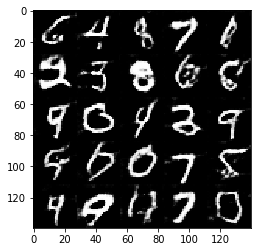

The Discriminator Loss is: 1.127... and the Generator Loss is: 1.117
The Discriminator Loss is: 1.142... and the Generator Loss is: 0.774
The Discriminator Loss is: 1.034... and the Generator Loss is: 1.188
The Discriminator Loss is: 1.423... and the Generator Loss is: 2.132
The Discriminator Loss is: 1.101... and the Generator Loss is: 1.199


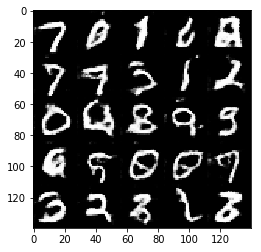

The Discriminator Loss is: 1.559... and the Generator Loss is: 0.440
The Discriminator Loss is: 1.302... and the Generator Loss is: 0.635
The Discriminator Loss is: 1.005... and the Generator Loss is: 1.041
The Discriminator Loss is: 1.410... and the Generator Loss is: 2.144
The Discriminator Loss is: 1.144... and the Generator Loss is: 0.951


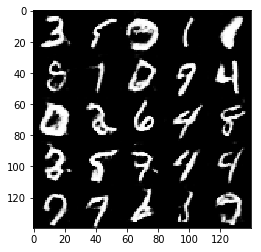

The Discriminator Loss is: 1.031... and the Generator Loss is: 1.289
The Discriminator Loss is: 1.018... and the Generator Loss is: 1.301
The Discriminator Loss is: 1.192... and the Generator Loss is: 1.052
The Discriminator Loss is: 1.169... and the Generator Loss is: 0.767
The Discriminator Loss is: 1.243... and the Generator Loss is: 0.707


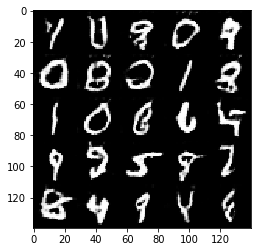

The Discriminator Loss is: 1.105... and the Generator Loss is: 1.082
The Discriminator Loss is: 1.454... and the Generator Loss is: 0.503
The Discriminator Loss is: 1.121... and the Generator Loss is: 0.979
The Discriminator Loss is: 1.134... and the Generator Loss is: 0.761
The Discriminator Loss is: 1.360... and the Generator Loss is: 0.558


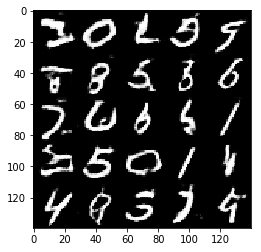

The Discriminator Loss is: 1.123... and the Generator Loss is: 0.761
The Discriminator Loss is: 1.218... and the Generator Loss is: 1.287
The Discriminator Loss is: 1.278... and the Generator Loss is: 0.617
The Discriminator Loss is: 1.575... and the Generator Loss is: 2.638
The Discriminator Loss is: 1.138... and the Generator Loss is: 0.725


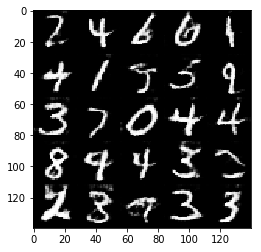

The Discriminator Loss is: 1.205... and the Generator Loss is: 0.956
The Discriminator Loss is: 1.149... and the Generator Loss is: 1.256
The Discriminator Loss is: 1.303... and the Generator Loss is: 1.361
The Discriminator Loss is: 1.051... and the Generator Loss is: 1.033
The Discriminator Loss is: 1.132... and the Generator Loss is: 1.374


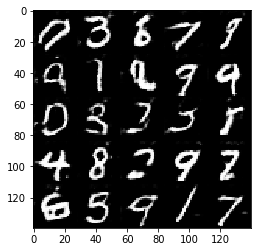

The Discriminator Loss is: 1.622... and the Generator Loss is: 2.436
The Discriminator Loss is: 1.099... and the Generator Loss is: 1.285
The Discriminator Loss is: 1.291... and the Generator Loss is: 0.625
The Discriminator Loss is: 1.102... and the Generator Loss is: 0.892
The Discriminator Loss is: 1.141... and the Generator Loss is: 1.404


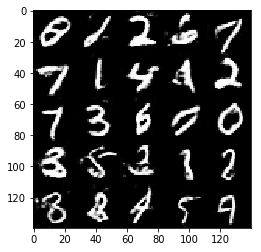

The Discriminator Loss is: 1.154... and the Generator Loss is: 0.843
The Discriminator Loss is: 1.179... and the Generator Loss is: 0.753
The Discriminator Loss is: 1.106... and the Generator Loss is: 1.474
The Discriminator Loss is: 1.244... and the Generator Loss is: 1.711
The Discriminator Loss is: 1.097... and the Generator Loss is: 1.612


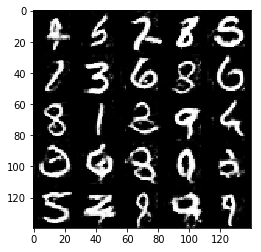

The Discriminator Loss is: 1.066... and the Generator Loss is: 0.987
The Discriminator Loss is: 1.272... and the Generator Loss is: 0.834
The Discriminator Loss is: 1.352... and the Generator Loss is: 2.075
The Discriminator Loss is: 1.188... and the Generator Loss is: 1.528
The Discriminator Loss is: 1.118... and the Generator Loss is: 0.804


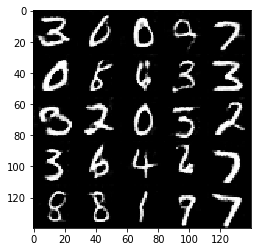

The Discriminator Loss is: 1.126... and the Generator Loss is: 0.869
The Discriminator Loss is: 1.127... and the Generator Loss is: 1.302
The Discriminator Loss is: 1.197... and the Generator Loss is: 0.764
The Discriminator Loss is: 1.090... and the Generator Loss is: 0.823


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

The Discriminator Loss is: 0.543... and the Generator Loss is: 2.280
The Discriminator Loss is: 0.426... and the Generator Loss is: 3.019
The Discriminator Loss is: 0.445... and the Generator Loss is: 2.840
The Discriminator Loss is: 0.822... and the Generator Loss is: 7.019


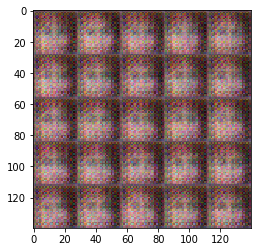

The Discriminator Loss is: 0.568... and the Generator Loss is: 1.841
The Discriminator Loss is: 0.474... and the Generator Loss is: 2.699
The Discriminator Loss is: 0.431... and the Generator Loss is: 3.062
The Discriminator Loss is: 0.400... and the Generator Loss is: 3.328
The Discriminator Loss is: 0.394... and the Generator Loss is: 3.298


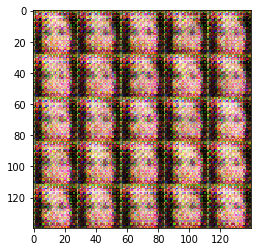

The Discriminator Loss is: 0.379... and the Generator Loss is: 3.913
The Discriminator Loss is: 0.372... and the Generator Loss is: 4.902
The Discriminator Loss is: 0.371... and the Generator Loss is: 4.462
The Discriminator Loss is: 0.362... and the Generator Loss is: 4.156
The Discriminator Loss is: 0.382... and the Generator Loss is: 3.626


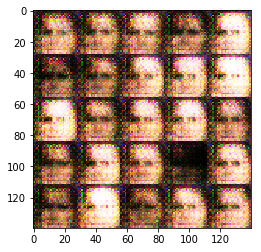

The Discriminator Loss is: 0.492... and the Generator Loss is: 2.602
The Discriminator Loss is: 0.579... and the Generator Loss is: 3.890
The Discriminator Loss is: 0.449... and the Generator Loss is: 2.851
The Discriminator Loss is: 0.513... and the Generator Loss is: 4.780
The Discriminator Loss is: 0.551... and the Generator Loss is: 2.278


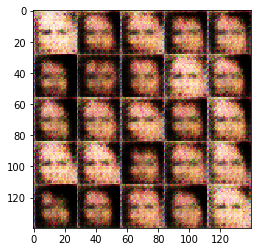

The Discriminator Loss is: 0.469... and the Generator Loss is: 3.498
The Discriminator Loss is: 0.584... and the Generator Loss is: 2.499
The Discriminator Loss is: 0.524... and the Generator Loss is: 2.175
The Discriminator Loss is: 0.464... and the Generator Loss is: 4.340
The Discriminator Loss is: 0.500... and the Generator Loss is: 2.960


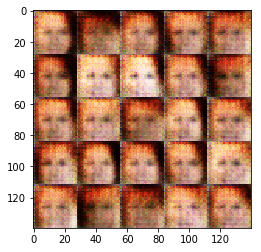

The Discriminator Loss is: 0.573... and the Generator Loss is: 2.007
The Discriminator Loss is: 0.441... and the Generator Loss is: 3.238
The Discriminator Loss is: 0.488... and the Generator Loss is: 2.905
The Discriminator Loss is: 1.198... and the Generator Loss is: 0.712
The Discriminator Loss is: 0.464... and the Generator Loss is: 3.140


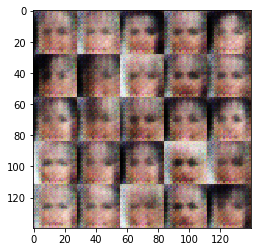

The Discriminator Loss is: 0.525... and the Generator Loss is: 3.197
The Discriminator Loss is: 0.513... and the Generator Loss is: 2.630
The Discriminator Loss is: 0.548... and the Generator Loss is: 2.278
The Discriminator Loss is: 0.450... and the Generator Loss is: 3.237
The Discriminator Loss is: 0.497... and the Generator Loss is: 3.753


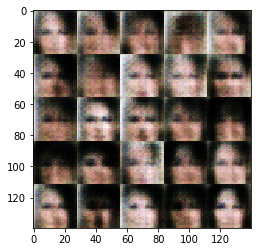

The Discriminator Loss is: 0.589... and the Generator Loss is: 1.810
The Discriminator Loss is: 0.474... and the Generator Loss is: 2.814
The Discriminator Loss is: 0.565... and the Generator Loss is: 2.072
The Discriminator Loss is: 0.530... and the Generator Loss is: 2.653
The Discriminator Loss is: 0.546... and the Generator Loss is: 2.279


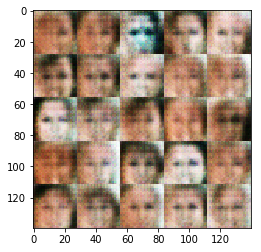

The Discriminator Loss is: 0.961... and the Generator Loss is: 4.798
The Discriminator Loss is: 0.578... and the Generator Loss is: 2.389
The Discriminator Loss is: 0.587... and the Generator Loss is: 3.209
The Discriminator Loss is: 0.497... and the Generator Loss is: 2.428
The Discriminator Loss is: 0.484... and the Generator Loss is: 2.749


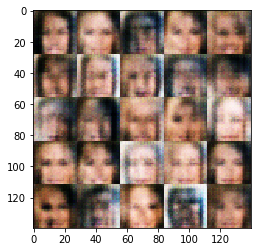

The Discriminator Loss is: 0.504... and the Generator Loss is: 2.852
The Discriminator Loss is: 0.531... and the Generator Loss is: 2.341
The Discriminator Loss is: 0.511... and the Generator Loss is: 2.819
The Discriminator Loss is: 0.532... and the Generator Loss is: 3.905
The Discriminator Loss is: 0.468... and the Generator Loss is: 2.674


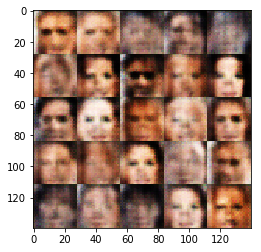

The Discriminator Loss is: 0.802... and the Generator Loss is: 1.242
The Discriminator Loss is: 0.484... and the Generator Loss is: 2.655
The Discriminator Loss is: 0.574... and the Generator Loss is: 2.135
The Discriminator Loss is: 0.700... and the Generator Loss is: 1.539
The Discriminator Loss is: 0.546... and the Generator Loss is: 2.896


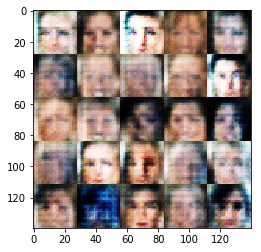

The Discriminator Loss is: 0.615... and the Generator Loss is: 1.963
The Discriminator Loss is: 1.014... and the Generator Loss is: 1.111
The Discriminator Loss is: 0.589... and the Generator Loss is: 2.253
The Discriminator Loss is: 0.638... and the Generator Loss is: 1.807
The Discriminator Loss is: 0.980... and the Generator Loss is: 0.998


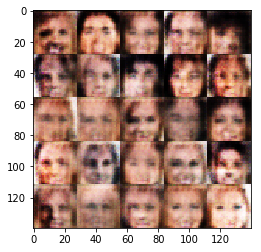

The Discriminator Loss is: 0.963... and the Generator Loss is: 3.502
The Discriminator Loss is: 0.629... and the Generator Loss is: 2.270
The Discriminator Loss is: 0.642... and the Generator Loss is: 1.774
The Discriminator Loss is: 0.566... and the Generator Loss is: 3.011
The Discriminator Loss is: 0.531... and the Generator Loss is: 2.280


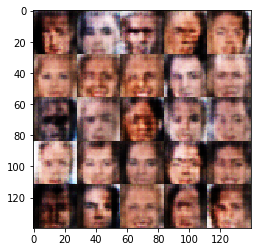

The Discriminator Loss is: 0.650... and the Generator Loss is: 2.223
The Discriminator Loss is: 0.585... and the Generator Loss is: 2.460
The Discriminator Loss is: 0.724... and the Generator Loss is: 1.866
The Discriminator Loss is: 0.667... and the Generator Loss is: 2.939
The Discriminator Loss is: 0.748... and the Generator Loss is: 1.679


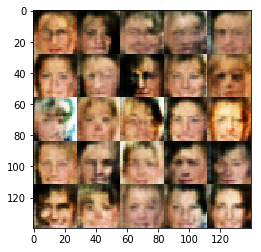

The Discriminator Loss is: 1.022... and the Generator Loss is: 0.978
The Discriminator Loss is: 0.747... and the Generator Loss is: 3.089
The Discriminator Loss is: 0.654... and the Generator Loss is: 1.706
The Discriminator Loss is: 0.662... and the Generator Loss is: 2.944
The Discriminator Loss is: 0.706... and the Generator Loss is: 1.728


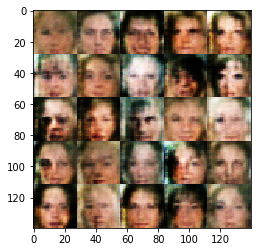

The Discriminator Loss is: 0.945... and the Generator Loss is: 4.274
The Discriminator Loss is: 0.619... and the Generator Loss is: 2.071
The Discriminator Loss is: 0.562... and the Generator Loss is: 2.313
The Discriminator Loss is: 0.703... and the Generator Loss is: 1.811
The Discriminator Loss is: 0.593... and the Generator Loss is: 2.839


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.